## Machine Learning para localizar Emisión Acústica (EA) en Rocas 


 Mi tema de tesis de doctorado esta enmarcado en el estudio de las ondas de Emision Acustica como precursores de grandes sismos, asi que decidi enfocar este trabajo práctico en buscar alguna aplicación a mi tema. Las emisiones acústicas (EA) son las ondas de tensión producidas por la repentina redistribución de la tensión interna de los materiales causada por los cambios en la estructura interna. Los cambios en la estructura interna pueden ser la iniciación de grietas dentro de la roca, apertura de grietas, fracturamiento, etc. La mayoría de las fuentes de EA están relacionadas con los daños; por lo tanto, la correcta localizacion de estas emisiones se utilizan habitualmente para predecir el fallo de los materiales. 






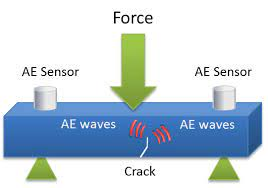

Para localizar las fuentes de EA usualmente se utilizan metodos similares al campo de la sismologia, y los más utilizados son los métodos de inversión del tiempo de recorrido de la onda (Geiger 1912; Aki y Lee 1976). Estos métodos se centran en torno al objetivo de resolver la relación no lineal entre el tiempo de viaje y la localización del hipocentro, lo que requiere modelos de velocidad constante predefinidos del medio (Richards et al.
2006). Para el caso caso que me interesa (localizacion de EA en rocas) la tarea se convierte en algo muy dificil cuando la roca tiene anisotropia. Esto requiere inversion tomografica de la muestra para establecer un modelo de velocidad y luego una inversion iterativa para localizar, lo cual es computacionalmente caro. En este trabajo práctico usaré algunos métodos de  Machine Learning para localizar la coordenada x,y usando solo los tiempos de arribo de la onda P, para eludir por completo la complejidad de establecer un modelo de velocidades y el proceso interativo de inversión. 

# **1. Adquisición de los datos**




Como por la pandemia aun no he podido realizar ensayos experimentales con mis muestras. Decidi buscar datos de ensayos de rotura de emision acústica en articulos donde liberaran los datos. Este es el caso de [blue_text](https://en.x-mol.com/paper/article/1225011219574341632). El montaje experimental consiste en un marco de carga, un sistema de registro EA  y el montaje de la muestra de roca (Fig. 1a). El montaje experimental se hizo con una muestra de roca tipo granito con dimensiones 218 mm x 218 mm x 200 mm  con un plano vertical de 45 grados en el centro (simulando una falla de laboratorio). Luego se aplica tension a la roca para obtener un deslizamiento por cizallamiento lateral derecho
en la falla de laboratorio a una tensión normal de falla de 10 MPa. Once sensores  piezoeléctricos  tipo Glaser fijados a la
a la muestra de roca en los lados norte (N) y oeste (W). Estos sensores se conectan directamente al digitalizador, que está conectado al computador  que registra las señales de EA.

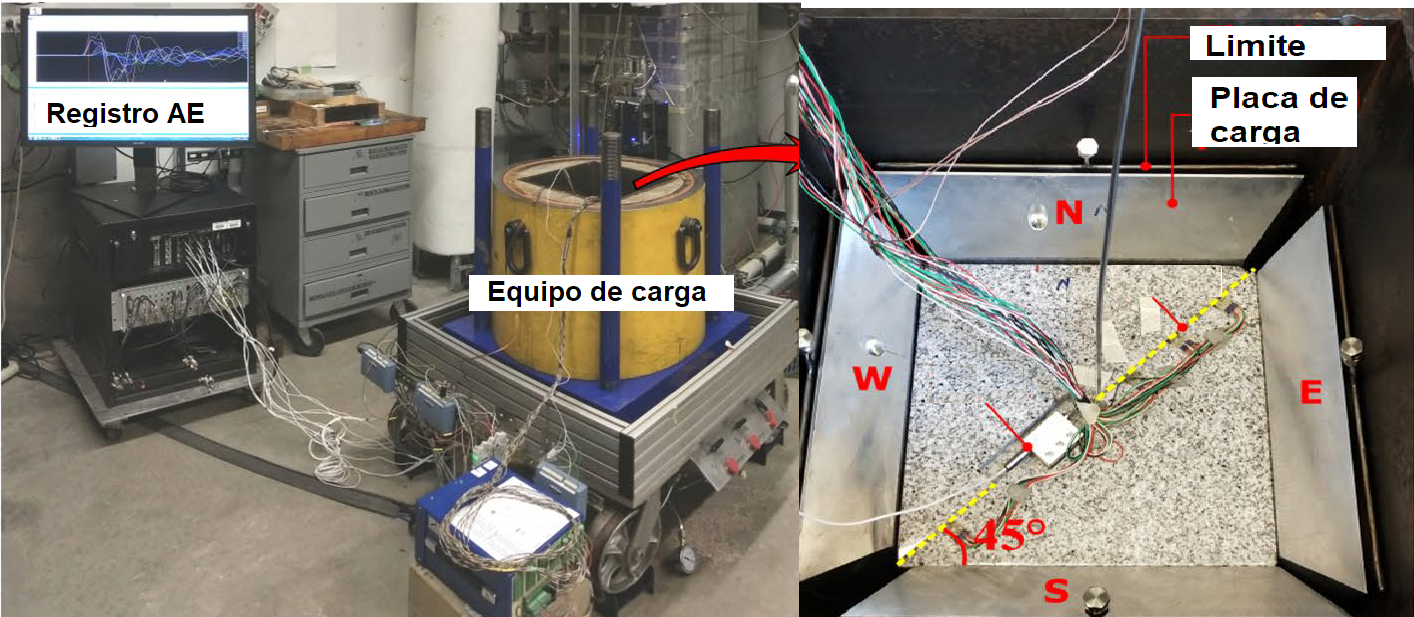

Se ralizaron 56 pruebas simulando una fuente de  EA mediante la 
ruptura de la mina de lápiz de 0,7 mm de diámetro en lugares conocidos
en la superficie de la falla (Hsu et al. 1978), antes de realizarse el ensayo de ruptura sobre la falla. Estos eventos se reparten por
toda la  superficie de la falla para asegurar una buena cobertura espacial. El tiempo de las ondas P se estimo con el criterio Akaike Information Criterion (AIC). A continuacion se muestra un ejemplo de como se recibio la señal en cada sensor y el picking de la onda P.

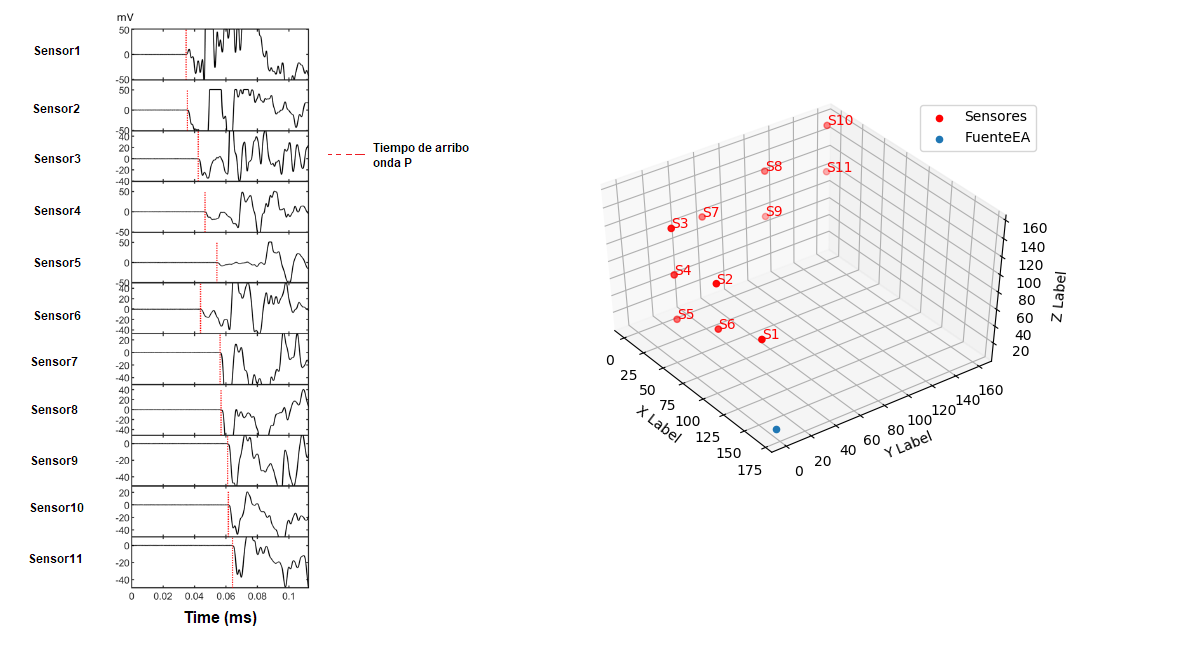

Las 56 pruebas de rotura de mina de lápiz  se hicieron sobre la superficie de falla. Como el eje Y se mantiene constante, se tomó como nuevo eje de coordenadas X,Z 

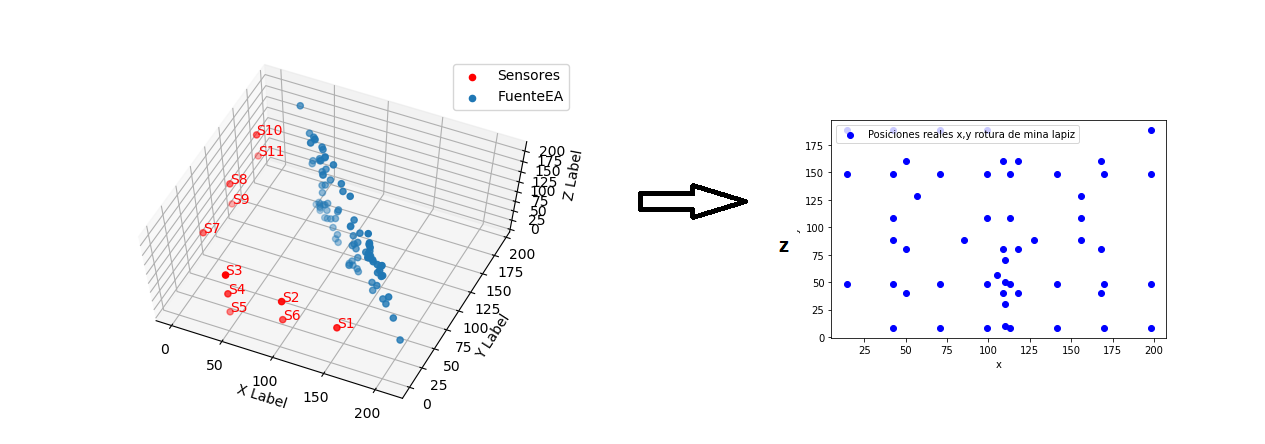

# **2. Explorando los datos**

In [3]:
import sklearn
import numpy as np
from numpy import array  
from numpy.linalg import norm
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from random import randrange
import math
import random
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

X_original = pd.read_csv("X.csv") #Datos originales
X = X_original.to_numpy()  #Lo paso a un array

t_original = pd.read_csv("T.csv") #Datos originales
t = t_original.to_numpy()  #Lo paso a un array



Los datos son los tiempos registrados por los sensores y la posicion donde se hizo la rotura de mina de lapiz. El imput seria los tiempos registrados por 11 sensores, y nuestro target las posiciones X,Z. Queremos realizar una regresion para predecir las posiciones X,Z del ensayo.
 

*   X_train: Tenemos una matriz de 56x11 que representan los 56 tiempos de la onda P eventos registrados por los 11 sensores.
*   T_train: Tenemos una matriz de 56x2 que representan las coordenadas X,Y conocidas 






# **3.Entrenamiento**

In [4]:
#Escaleamos los datos

X= StandardScaler().fit_transform(X)


In [5]:
#Separamos el conjunto de entrenamiento en entranamiento y validacion

from sklearn.model_selection import train_test_split
X_train, X_test, t_train, t_test = train_test_split(X, t, test_size=0.2,random_state=42) 

## **3.1 Usando SVM**

In [9]:
#Buscamos por Validacion Cruzada  los mejores hiperparametros para el modelo

from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipe_svr = Pipeline([('scl', StandardScaler()),
        ('reg', MultiOutputRegressor(SVR()))])

grid_param_svr = {
    'reg__estimator__C': np.arange(10,1000,10),
    'reg__estimator__epsilon': np.arange(0.1,10.0,0.1)
    
}

gs_svr = (GridSearchCV(estimator=pipe_svr, 
                      param_grid=grid_param_svr, 
                      cv=5,
                      scoring = 'neg_mean_squared_error',
                      n_jobs = -1))

gs_svr = gs_svr.fit(X_train,t_train)
gs_svr.best_estimator_    


Pipeline(memory=None,
         steps=[('scl',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('reg',
                 MultiOutputRegressor(estimator=SVR(C=320, cache_size=200,
                                                    coef0=0.0, degree=3,
                                                    epsilon=2.3000000000000003,
                                                    gamma='scale', kernel='rbf',
                                                    max_iter=-1, shrinking=True,
                                                    tol=0.001, verbose=False),
                                      n_jobs=None))],
         verbose=False)

In [10]:
#Entrenamos el algoritmo en X
model_svm=gs_svr.best_estimator_    
t_train_predictSVM= model_svm.predict(X_train)


In [11]:
#Evaluamos su performance del algoritmo

mse_x_train_SVM = mean_squared_error(t_train, t_train_predictSVM)
print(f'MSE for train: {mse_x_train_SVM}')


MSE for train: 58.43612606466875


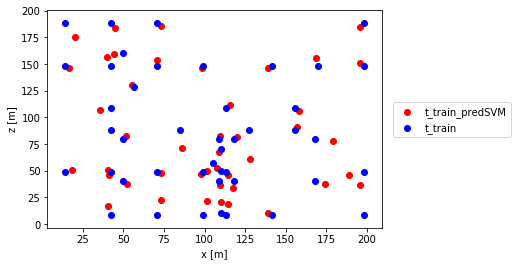

In [12]:
#Ploteamos las predicciones en Train

plt.scatter(t_train_predictSVM[:,0],t_train_predictSVM[:,1],color='red', marker='o', label='t_train_pred')
plt.scatter(t_train[:,0],t_train[:,1],color='blue', marker='o', label='t_train')
plt.xlabel('x [m]')
plt.ylabel('z [m]')
plt.legend(["t_train_predSVM","t_train"],
           bbox_to_anchor = (1.4, 0.6))

## **3.2 Usando Ridge Regression**

In [14]:
#Encontrando mejor polinomio  incorporando Regularizacion Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge

def ridge(m, lam):
    return Pipeline([('poly_features', PolynomialFeatures(degree=m)),
                     ('regressor', Ridge(alpha=lam/2.0, fit_intercept=False))])

# Fit Ridge con polinomio 10 y alpha seleccionado
#model_ridge = ridge(10, 0.0002782559402207126)
model_ridge = ridge(10, 0.01)
model_ridge.fit(X_train, t_train)

Pipeline(memory=None,
         steps=[('poly_features',
                 PolynomialFeatures(degree=10, include_bias=True,
                                    interaction_only=False, order='C')),
                ('regressor',
                 Ridge(alpha=0.005, copy_X=True, fit_intercept=False,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

In [15]:
#Entrenamos el algoritmo en X
  
t_train_predictridge= model_ridge.predict(X_train)


In [16]:
#Evaluamos su performance del algoritmo

mse_x_train_ridge = mean_squared_error(t_train, t_train_predictridge)
print(f'MSE for train: {mse_x_train_ridge}')


MSE for train: 0.013281605367409887


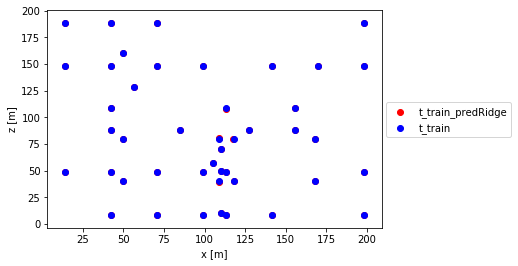

In [17]:
#Ploteamos las predicciones en Train

plt.scatter(t_train_predictridge[:,0],t_train_predictridge[:,1],color='red', marker='o', label='t_train_pred')
plt.scatter(t_train[:,0],t_train[:,1],color='blue', marker='o', label='t_train')
plt.xlabel('x [m]')
plt.ylabel('z [m]')
plt.legend(["t_train_predRidge","t_train"],
           bbox_to_anchor = (1.4, 0.6))

## **3.2 Usando Decision Tree Regression**

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

#modelo_dt = DecisionTreeRegressor(max_depth=2)
dt = DecisionTreeRegressor()

parametros={'max_depth':[2,3,5,7,10],'min_samples_leaf':list(range(1, 40))}
grid_dt=GridSearchCV(dt,parametros,cv=10,scoring='neg_mean_squared_error')
grid_dt.fit(X_train,t_train)
grid_dt.best_estimator_ 

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=5,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [19]:
#Entrenamos el algoritmo en X
model_dt=grid_dt.best_estimator_    
t_train_predictDT= model_dt.predict(X_train)

In [20]:
#Evaluamos su performance del algoritmo

mse_x_train_DT = mean_squared_error(t_train, t_train_predictDT)
print(f'MSE for train: {mse_x_train_DT}')

MSE for train: 158.22843140909436


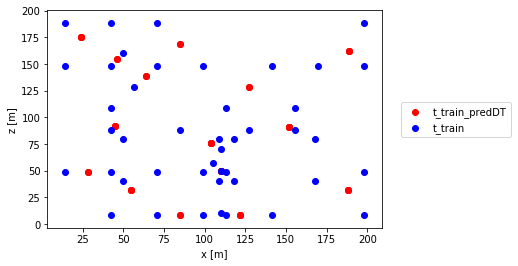

In [21]:
#Ploteamos las predicciones en Train

plt.scatter(t_train_predictDT[:,0],t_train_predictDT[:,1],color='red', marker='o', label='t_train_pred')
plt.scatter(t_train[:,0],t_train[:,1],color='blue', marker='o', label='t_train')
plt.xlabel('x [m]')
plt.ylabel('z [m]')
plt.legend(["t_train_predDT","t_train"],
           bbox_to_anchor = (1.4, 0.6))

## **3.3 Comparacion Metricas Train**

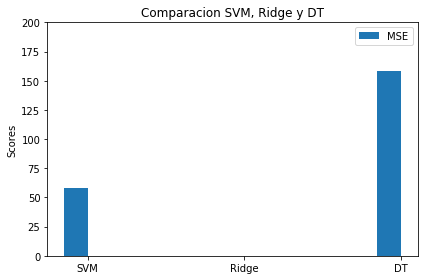

MSE for train SVM: 58.43612606466875
MSE for train Ridge: 0.013281605367409887
MSE for train DT: 158.22843140909436


In [22]:
# importing package
import matplotlib.pyplot as plt
import numpy as np
  
labels = ['SVM', 'Ridge', 'DT']
MSE = [mse_x_train_SVM, mse_x_train_ridge,mse_x_train_DT]


x = np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, MSE, width, label='MSE')
ax.set_ylim(ymin=0,ymax=200)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Comparacion SVM, Ridge y DT')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

print(f'MSE for train SVM: {mse_x_train_SVM}')
print(f'MSE for train Ridge: {mse_x_train_ridge}')
print(f'MSE for train DT: {mse_x_train_DT}')


De acuerdo a los resultados en el conjunto de entreamiento, el modelo que mejor tiene performance en dicho dataset es el modelo Regression Ridge. 

# **4.Testeo**

Ahora probamos con datos que no ha visto el modelo. De esta manera escoger el mejor modelo

In [23]:
#Ploteamos las predicciones en Test
t_test_predictSVM= model_svm.predict(X_test)
t_test_predictRidge= model_ridge.predict(X_test)
t_test_predictDT= model_dt.predict(X_test)

In [24]:
#Evaluamos en Test

mse_x_test_SVM = mean_squared_error(t_test, t_test_predictSVM)
mse_x_test_Ridge = mean_squared_error(t_test, t_test_predictRidge)
mse_x_test_DT = mean_squared_error(t_test, t_test_predictDT)
print(f'MSE for test SVM: {mse_x_test_SVM}')
print(f'MSE for test Ridge: {mse_x_test_Ridge}')
print(f'MSE for test DT: {mse_x_test_DT}')

MSE for test SVM: 54.52534197094012
MSE for test Ridge: 79087.29506009955
MSE for test DT: 437.60879496632464


# **5.Conclusiones**

Se observa como el valor de la metrica del modelo SVM se mantiene tanto en el conjunto de entrenamiento y testeo. El modelo de Ridge completamente sobreajusto y por eso no le atina en nada al conjunto de Testeo. Y el modelo de DT aumento el error en el conjunto de testeo. Es claro que en una primera instancia el mejor tipo de regression para este conjunto de datos es el SVM. Seguramente mejorar su metrica requiera de mas datos y de optimizar mejor su performance. Es un gran avance a primera instancia, ya que esta herramienta puede ser de gran utilidad para observar rapidamente donde se encuentra la zona de localizacion de EA. 

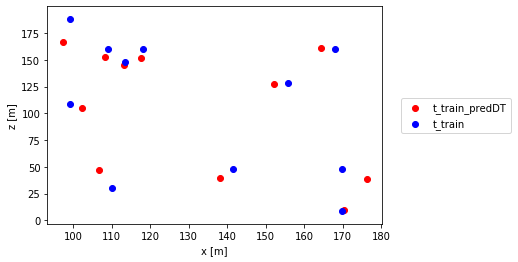

In [25]:
plt.scatter(t_test_predictSVM[:,0],t_test_predictSVM[:,1],color='red', marker='o')
plt.scatter(t_test[:,0],t_test[:,1],color='blue', marker='o')
plt.xlabel('x [m]')
plt.ylabel('z [m]')
plt.legend(["t_train_predDT","t_train"],
           bbox_to_anchor = (1.4, 0.6))

# **6.Adicional (Input Ensayo ruptura roca)**

Como tambien tenia los datos de un ensayo de rotura que se hizo en la parte superior del bloque de granito, quise probar el modelo con estos datos. Aunque no tenga la posicion real, es bastante satisfactorio si las localizaciones se observan sobre el borde superior del granito. Se registraron 96 eventos de Emision Acustica mientras se hacia el ensayo. Para cada uno de estos eventos se registro el tiempo de arribo de la onda P. 

In [26]:
X_ensayo_original = pd.read_csv("x_ensayo.csv") #Datos originales
X_ensayo = X_ensayo_original.to_numpy()  #Lo paso a un array
X_ensayo = StandardScaler().fit_transform(X_ensayo)
t_test_predictEnsayo= model_svm.predict(X_ensayo)

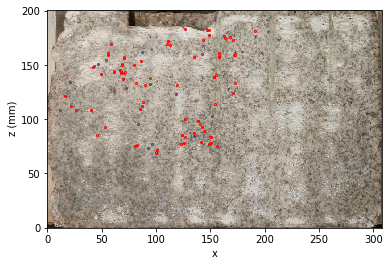

In [30]:
#Ploteamos sobre la imagen 

from PIL import Image
import math 

im = Image.open('muestra_despues_ensayo.jpg')
L= 218
H= 200
scle = 2
img = im.resize((924, 600))
plt.axes().set_aspect('equal')
plt.imshow(img)

x=t_test_predictEnsayo[:,0]
z=t_test_predictEnsayo[:,1]
y=L-x

N = len(x)
labelsx = ['0','50','100','150','200','250','300']
labelsy= ['200','150','100','50','0']
for i in range(N):

    x_on_fault = scle*(L+x[i]-y[i])/2
    dist_on_fault = math.sqrt(2)*(scle*L-x_on_fault)
    depth_on_fault = scle*H-scle*z[i]
    plt.plot(dist_on_fault,depth_on_fault,marker="o",ms = 2, mec = 'r')
    plt.xlabel("x")
    plt.ylabel(" z (mm)")
    plt.xticks(([0,150,300,450,600,750,900]),labelsx)
    plt.yticks(([0,150,300,450,600]), labelsy)

Se observa que las localizaciones estan sobre el borde. Estos resultados me dejan ampliamente satisfecha con esta primera aproximacion. 